In [1]:
from modules import credentials, osrm, utilities, docker_functions

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import requests
from IPython.display import JSON

import plotly.express as px
import plotly.graph_objects as go

import polyline
import folium

import docker

# Open Calgary API
from sodapy import Socrata

## Load Data from OpenCalgary

### API call

In [59]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.calgary.ca",  credentials.OPEN_YYC_APP_TOKEN)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.calgary.ca,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9zvu-p8uz", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [35]:
results_df

address   street_name street_type street_quad  \
0         38 LAVENDER DR SE      LAVENDER          DR          SE   
1         73 LAVENDER RD SE      LAVENDER          RD          SE   
2            4526 16A ST SW           16A          ST          SW   
3         39 LAVENDER MR SE      LAVENDER          MR          SE   
4     632 RUNDLERIDGE DR NE   RUNDLERIDGE          DR          NE   
...                     ...           ...         ...         ...   
1995   1160 CRANBROOK GD SE     CRANBROOK          GD          SE   
1996   296 LIVINGSTON VW NW    LIVINGSTON          VW          NW   
1997  59 HIDDEN RANCH RD NW  HIDDEN RANCH          RD          NW   
1998    2713 MONTCALM CR SW      MONTCALM          CR          SW   
1999    5918 BOWWATER CR NW      BOWWATER          CR          NW   

     house_number address_type            longitude            latitude  \
0              38       Parcel  -113.91013339496129  50.884413712226646   
1              73       Parcel  -113.91160953139034   50.88362372064759   
2            4526       Parcel  -114.10176682267128   51.01335933981784   
3              39       Parcel  -113.91287080182607   50.88388537837258   
4             632       Parcel  -113.97836870271072  51.070711227786454   
...           ...          ...                  ...                 ...   
1995         1160       Parcel  -113.97977178674498  50.863747080979884   
1996          296       Parcel  -114.07630240005403  51.190155646523785   
1997           59       Parcel  -114.12481304696747   51.14736417139583   
1998         2713       Parcel  -114.09102974053373  51.029356506234095   
1999         5918       Parcel   -114.1701983959963  51.083035560965904   

                                               location  \
0     {'latitude': '50.884413712226646', 'longitude'...   
1     {'latitude': '50.88362372064759', 'longitude':...   
2     {'latitude': '51.01335933981784', 'longitude':...   
3     {'latitude': '50.88388537837258', 'longitude':...   
4     {'latitude': '51.070711227786454', 'longitude'...   
...                                                 ...   
1995  {'latitude': '50.863747080979884', 'longitude'...   
1996  {'latitude': '51.190155646523785', 'longitude'...   
1997  {'latitude': '51.14736417139583', 'longitude':...   
1998  {'latitude': '51.029356506234095', 'longitude'...   
1999  {'latitude': '51.083035560965904', 'longitude'...   

     :@computed_region_4a3i_ccfj :@computed_region_4b54_tmc4  \
0                              3                           4   
1                              3                           4   
2                              1                           8   
3                              3                           4   
4                              4                           9   
...                          ...                         ...   
1995                           3                           4   
1996                           2                          11   
1997                           2                           2   
1998                           1                          14   
1999                           2                          13   

     :@computed_region_kxmf_bzkv :@computed_region_hq2j_w7j9  \
0                            222                         147   
1                            222                         147   
2                            200                         267   
3                            222                         147   
4                             34                         291   
...                          ...                         ...   
1995                         294                          82   
1996                         246                          10   
1997                          25                         289   
1998                         271                         185   
1999                         149                          77   

     :@computed_region_p8tp_5dkv house_alph

In [4]:
results_df.to_csv('openYYCtestdata.csv', index=False)

### From file

In [200]:
gdf = utilities.load_data()

In [69]:
# Load saved sample file
add = pd.read_csv(
    '../data/openYYCtestdata.csv',
    usecols=['address', 'longitude', 'latitude']
)

gdf = utilities.df_to_geodf(add)
gdf.head(2)

address   longitude   latitude                     geometry
0  5532 DALWOOD WY NW -114.162743  51.114109  POINT (-114.16274 51.11411)
1  321 MAGNOLIA HE SE -113.914848  50.891335  POINT (-113.91485 50.89134)

## Steps

1. intake address data (.csv) 24 aero dr.
  - preprocess
2. Geocode addresses
  - Open Calgary Parcel Address
  - Google Maps
  - Foursquare
3. Time and distance matrix
  - OSRM
  - OpenRouteService
    - Both OSRM and ORS require an OpenStreetMap (OSM) Protocolbuffer (.pbf) file
      - [Geofabrik Alberta](https://download.geofabrik.de/north-america/canada/alberta.html)
        - [alberta-latest.osm.pbf](https://download.geofabrik.de/north-america/canada/alberta-latest.osm.pbf)
      - [BBBike Calgary](https://download.bbbike.org/osm/bbbike/Calgary/)
        - [Calgary.osm.pbf](https://download.bbbike.org/osm/bbbike/Calgary/Calgary.osm.pbf)
        - [Custom region](https://extract.bbbike.org/)
      - [Processed data providers](https://wiki.openstreetmap.org/wiki/Processed_data_providers)
        - interline has an API, data is updated daily [planetUtils](https://github.com/interline-io/planetutils) However it cuts Okatokes in half
      
  - Google Maps
  - Mapbox
4. Cluster into routes
  - by driving distance
  - by driving time
  - elbow rule, optimal routes
  - sklearn DBScan precalculated distance
  - test with sklearn.pairwise distance for euclidean distances
5. Time and distance matrix (the matrix from pt. 3 should be usable for this)
6. Route sequence TSP
  - OSM
  - OpenRouteService
7. Evaluate
  - R4M

### Open Source Routing Machine (OSRM)

- [Documentation](http://project-osrm.org/docs/v5.24.0/api/?language=Python)
- [GitHub](https://github.com/Project-OSRM)
- [Docker Images](https://hub.docker.com/u/osrm)

Tutorials

- [Kick Start — Open Source Routing Machine Set-Up](https://medium.com/ivymobility-developers/open-source-routing-machine-43db9ae06fb7) Docker backend
- [Python Tutorial of OSRM(Open Sourced Routing Machine) and Applications](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/) Uses folium to display maps
- [OSRM and VROOM](https://medium.com/@calroughan/a-beginners-guide-to-installing-osrm-and-vroom-on-gcp-28fbcf1f7857)


In [3]:
container = docker_functions.start_Docker_container()

In [26]:
container.stop()

#### Set up docker container

Pre-process the extract with the car profile
GCA : Greater Calgary Area
${PWD} : Assumed to be top project directory

```shell
docker run -t -v "${PWD}/data/GCA:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/planet_-114.516_50.685_7e77eeeb.osm.pbf
```

Note change in osrm action and file extension

```shell
docker run -t -v "${PWD}/data/GCA:/data" osrm/osrm-backend osrm-partition /data/planet_-114.516_50.685_7e77eeeb.osrm                 
```

```shell
docker run -t -v "${PWD}/data/GCA:/data" osrm/osrm-backend osrm-customize /data/planet_-114.516_50.685_7e77eeeb.osrm                 
```

```shell
docker run -t -i -p 8080:5000 -v "${PWD}/data/GCA:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/planet_-114.516_50.685_7e77eeeb.osrm
```

This process creates four separate Docker containers. I need to find out if the process is necessary or if I can add `--rm` to remove the container when it exits.  
Add `--name osrm-app`

To start existing container
```shell
docker start upbeat_neumann
```

#### Table Service

In [120]:
# https://cityonline.calgary.ca/gismap/mainmap.aspx
N = 51.212
S = 50.843
E = -113.86
W = -114.316
centre = ((N+S)/2, (E+W)/2)

In [126]:
centre

(51.0275, -114.088)

In [127]:
gdf.describe()

longitude     latitude        route
count  2000.000000  2000.000000  2000.000000
mean   -114.070251    51.041104     1.686500
std       0.087943     0.091690     2.972648
min    -114.274050    50.855402     0.000000
25%    -114.130616    50.958636     0.000000
50%    -114.075903    51.055863     0.000000
75%    -113.988340    51.119730     2.000000
max    -113.906266    51.207557    10.000000

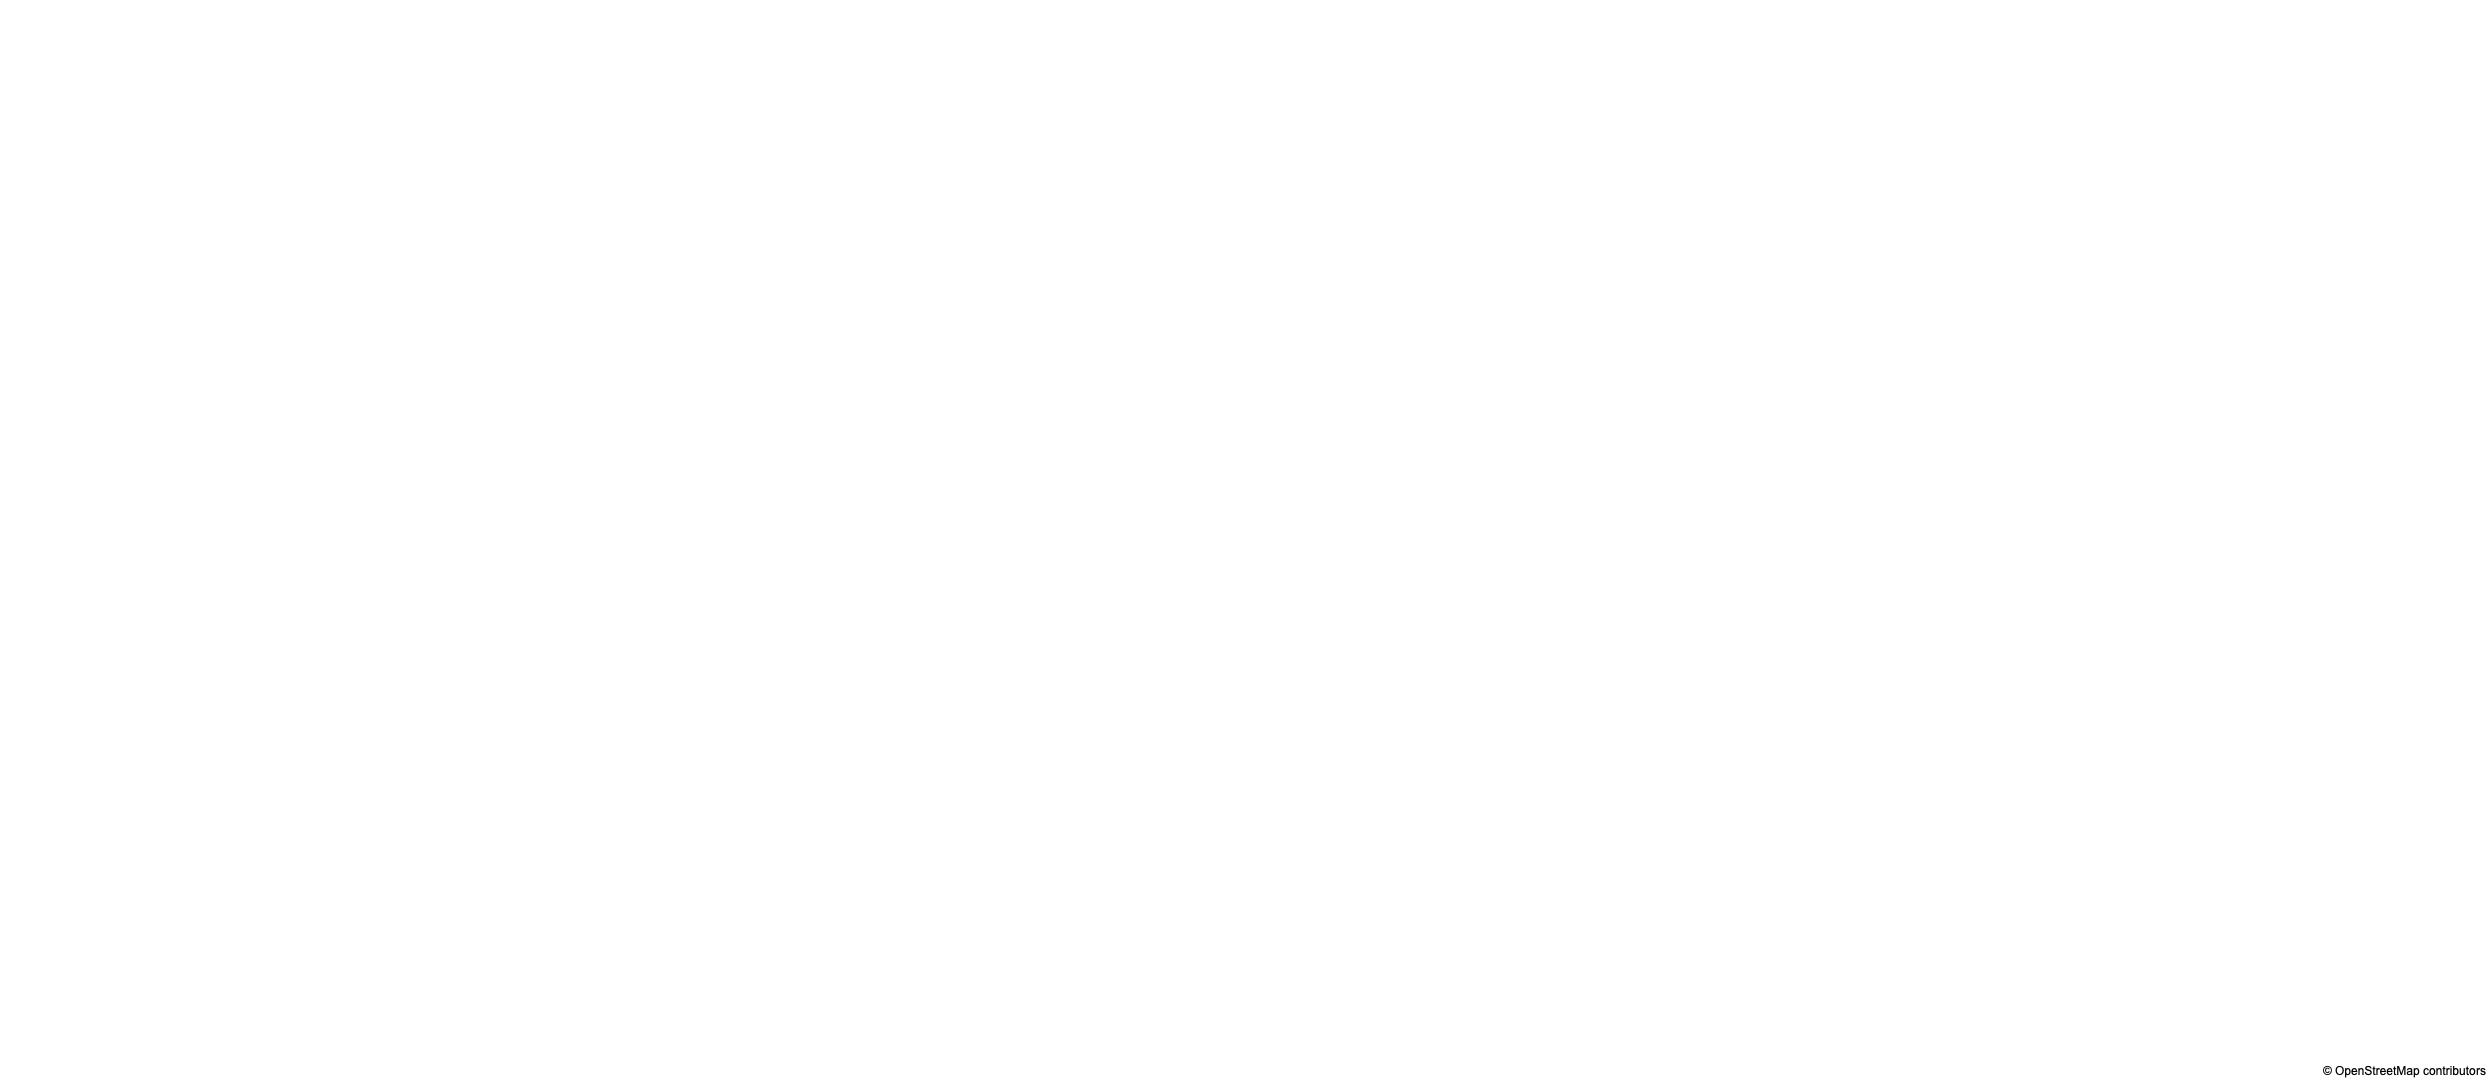

In [133]:
# Plot all address points
fig = px.scatter_mapbox(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,

    mapbox_style='open-street-map',
    hover_name=gdf.address,
    opacity=0.85,
    width=1920,
    height=1080,
    zoom=10.3,
    center={'lat': centre[0],
            'lon': centre[1]},
    color_discrete_sequence=px.colors.qualitative.D3,
)
fig2 = px.scatter_mapbox(
    WAREHOUSE,
    lat=WAREHOUSE.geometry.y,
    lon=WAREHOUSE.geometry.x,
    # center={'lat': 51.041104,
            # 'lon': -114.070251},
    # mapbox_style='open-street-map',
    # hover_name=WAREHOUSE.address,
    opacity=0.85,
    color_discrete_sequence=['red']
    # width=1600,
    # height=900,
    # zoom=10
)
fig.add_trace(fig2.data[0])

fig.update_layout(
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
)

fig.show()

In [134]:
fig.write_image('fig1.png', scale=3)

In [9]:
OSRM_API = osrm.OSRM()

In [ ]:
# OSRM_API.large_table(locations=add)
# distance and duration tables took 727.3 s / 12.1 min
# average 1.82s/table

In [155]:
dm = pd.read_csv('../data/duration_matrix_20220216-222102.csv', header=None)

In [176]:
fig = px.imshow(
    dm,
    color_continuous_scale=px.colors.sequential.Oranges,
    width=1080,
    height=1080,
)

fig.update_layout(
    xaxis={'visible': False},
    yaxis={'visible': False},
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
    coloraxis_showscale=False
)

# fig.show()
fig.write_image('../output/figures/duration_matrix.png')

### Open Route Service 

- [Documentation](https://openrouteservice.org/dev/#/api-docs/introduction)
- [Docker Image](https://hub.docker.com/u/openrouteservice)
- [Python SDK](https://github.com/GIScience/openrouteservice-py)

ORS is not adequate for this use case.
- the distance matrix only computes 10 locations
- geocoding is handled by third party pelias
- Docker image is 10x the size of OSRM

#### Set Up Docker Container

for arm64
```shell
docker run -dt -u "${UID}:${GID}" --name ors-app -p 8080:8080 -v $PWD/graphs:/ors-core/data/graphs -v $PWD/elevation_cache:/ors-core/data/elevation_cache -v $PWD/conf:/ors-conf -v $PWD/planet_-114.516_50.685_7e77eeeb.osm.pbf:/ors-core/data/osm_file.pbf -e "JAVA_OPTS=-Djava.awt.headless=true -server -XX:TargetSurvivorRatio=75 -XX:SurvivorRatio=64 -XX:MaxTenuringThreshold=3 -XX:+UseG1GC -XX:+ScavengeBeforeFullGC -XX:ParallelGCThreads=4 -Xms1g -Xmx2g" -e "CATALINA_OPTS=-Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.port=9001 -Dcom.sun.management.jmxremote.rmi.port=9001 -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Djava.rmi.server.hostname=localhost" marteze/openrouteservice:latest
```
It takes ≈5min to get set up the first time

#### ors

In [61]:
add = pd.read_csv(
    'openYYCtestdata.csv',
    usecols=['longitude', 'latitude'],
    nrows=10
)

add['location'] = list(zip(add['longitude'], add['latitude']))  # 10x faster than .apply(tuple)

add

0.0068988800048828125
0.061615943908691406


longitude   latitude                                   location  \
0 -114.162743  51.114109   (-114.16274336722891, 51.11410863370181)   
1 -113.914848  50.891335    (-113.9148479931804, 50.89133503430436)   
2 -113.981177  50.888362   (-113.98117686841113, 50.88836183031347)   
3 -114.150439  51.178209  (-114.15043875308372, 51.178208654570426)   
4 -114.031285  51.041928    (-114.03128504301664, 51.0419284690263)   
5 -114.018978  50.928064    (-114.0189778287356, 50.92806426764464)   
6 -113.941001  51.086881    (-113.9410012253191, 51.08688066663724)   
7 -113.928686  50.900550    (-113.92868579137446, 50.9005500311767)   
8 -114.095787  51.139221    (-114.09578716715303, 51.1392207119003)   
9 -114.088736  51.035155  (-114.08873594641553, 51.035155430531184)   

                                   location2  
0   (-114.16274336722891, 51.11410863370181)  
1    (-113.9148479931804, 50.89133503430436)  
2   (-113.98117686841113, 50.88836183031347)  
3  (-114.15043875308372, 51.178208654570426)  
4    (-114.03128504301664, 51.0419284690263)  
5    (-114.0189778287356, 50.92806426764464)  
6    (-113.9410012253191, 51.08688066663724)  
7    (-113.92868579137446, 50.9005500311767)  
8    (-114.09578716715303, 51.1392207119003)  
9  (-114.08873594641553, 51.035155430531184)

In [ ]:
gdf = gpd.GeoDataFrame(
    add, geometry=gpd.points_from_xy(add['longitude'], add['latitude'])
)
gdf

In [72]:
coords = ((-114.2341,51.1433),(-114.2529,51.1321))

# key can be omitted for local host
ors_client = openrouteservice.Client(base_url='http://localhost:8080/ors/v2')

In [ ]:
point = ors_client.pelias_search(text='Namibian Brewery')

In [60]:
matrix = ors_client.distance_matrix(add['location'].to_list())

In [56]:
JSON(matrix)

<IPython.core.display.JSON object>

In [54]:
pd.json_normalize(matrix, record_path=['durations'])

0        1        2        3        4        5        6        7  \
0     0.00  2612.79  2366.28  1096.07  1404.66  2054.83  1579.24  2497.29   
1  2594.60     0.00   920.99  2835.14  1681.74  1417.11  1662.85   307.12   
2  2378.68   936.66     0.00  2619.23  1465.82  1201.19  1783.65   858.02   
3  1071.68  2879.31  2632.80     0.00  1739.04  2321.35  1833.81  2763.81   
4  1395.04  1674.88  1428.37  1790.25     0.00  1116.91  1131.48  1559.38   
5  2061.57  1353.07  1106.56  2302.12  1148.71     0.00  1643.35  1237.57   
6  1586.01  1672.15  1676.97  1824.20  1107.93  1690.23     0.00  1556.65   
7  2484.75   312.77   863.84  2725.30  1571.89  1307.26  1553.00     0.00   
8   772.03  2235.64  1989.13   917.98  1095.37  1677.67  1331.06  2120.14   
9  1183.23  2059.03  1812.52  1850.69   561.47  1501.06  1429.13  1943.53   

         8        9  
0   716.48  1172.50  
1  2190.93  2074.23  
2  1975.01  1858.31  
3   918.45  1920.30  
4  1146.03   541.25  
5  1657.90  1541.20  
6  1227.89  1390.01  
7  2081.08  1964.38  
8     0.00  1256.17  
9  1253.09     0.00

In [16]:
routes = ors_client.directions(coords)

In [20]:
JSON(routes)

<IPython.core.display.JSON object>

In [30]:
pd.json_normalize(routes['routes'])

segments  \
0  [{'distance': 4584.5, 'duration': 373.5, 'step...   

                                              bbox  \
0  [-114.257566, 51.13207, -114.234101, 51.149468]   

                                            geometry way_points  \
0  s|cwHbjfxT}H?iA@M?U??d@T?L?xHCh@RXTJ\Hf@?rBE|K...   [0, 105]   

   summary.distance  summary.duration  
0            4584.5             373.5

In [27]:
df = utilities.polyline_to_geodf(routes['routes'][0]['geometry'])
df

latitude  longitude                     geometry
0    51.14330 -114.23410  POINT (-114.23410 51.14330)
1    51.14489 -114.23410  POINT (-114.23410 51.14489)
2    51.14526 -114.23411  POINT (-114.23411 51.14526)
3    51.14533 -114.23411  POINT (-114.23411 51.14533)
4    51.14544 -114.23411  POINT (-114.23411 51.14544)
..        ...        ...                          ...
101  51.13231 -114.25376  POINT (-114.25376 51.13231)
102  51.13227 -114.25347  POINT (-114.25347 51.13227)
103  51.13220 -114.25322  POINT (-114.25322 51.13220)
104  51.13215 -114.25309  POINT (-114.25309 51.13215)
105  51.13207 -114.25294  POINT (-114.25294 51.13207)

[106 rows x 3 columns]

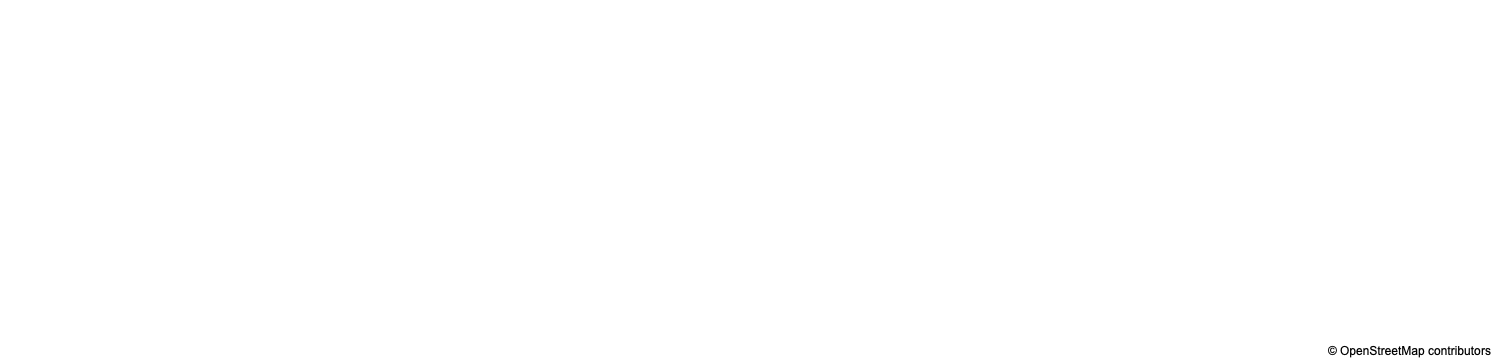

In [29]:
fig = px.line_mapbox(
    df,
    lat=df.geometry.y,
    lon=df.geometry.x,
    mapbox_style='open-street-map',
    
)
# fig.update_geos(fitbounds='locations')
fig.update_layout(
    # title='title',
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
)
fig.show()

### Google Maps

- [Python SDK](https://github.com/googlemaps/google-maps-services-python)
- [`googlemaps` docs](https://googlemaps.github.io/google-maps-services-python/docs/index.html)

#### From API

In [10]:
WAREHOUSE = utilities.googlemaps_geocode('24 Aero Dr NE, Calgary')
WAREHOUSE

latitude   longitude        address                     geometry
0  51.119691 -114.031698  24 AERO DR NE  POINT (-114.03170 51.11969)

In [105]:
JSON(geocode_result[0])

<IPython.core.display.JSON object>

In [181]:
pd.json_normalize(geocode_result[0], record_path=['address_components'])

long_name         short_name  \
0                    24                 24   
1  Aero Drive Northeast         Aero Dr NE   
2     Northeast Calgary  Northeast Calgary   
3               Calgary            Calgary   
4               Alberta                 AB   
5                Canada                 CA   
6               T2E 8Z9            T2E 8Z9   

                                      types  
0                           [street_number]  
1                                   [route]  
2                 [neighborhood, political]  
3                     [locality, political]  
4  [administrative_area_level_1, political]  
5                      [country, political]  
6                             [postal_code]

#### From record

In [17]:
# Front gate
WAREHOUSE = {
    'latitude': 51.11894525704247,
    'longitude': -114.03141847427416
}

In [54]:
# Saved API result
WAREHOUSE = pd.DataFrame({
    'latitude': {0: 51.1196913},
    'longitude': {0: -114.0316978},
    'address': {0: '24 AERO DR NE'}
})
WAREHOUSE = utilities.df_to_geodf(WAREHOUSE)
WAREHOUSE

latitude   longitude        address                     geometry
0  51.119691 -114.031698  24 AERO DR NE  POINT (-114.03170 51.11969)

In [3]:
WAREHOUSE = utilities.get_warehouse()

OSRM solves TSP not VRP  
ORS solves TSP and VRP. It solves VRP using VROOM.  
VROOM optimizes routes using cost tables from OSRM, ORS, or Valhala  
Valhala solves TSP  

Rather than using ORS or VROOM to solve the VRP. I am going to use sklearn.DBScan. After routes are clustered then I use the APIs to solve the TSP.

## Clustering

Clustering with precomputed distance matrix
- DBScan
- Agglomerative clustering

### DBScan

Density-Based Spatial Clustering of Applications with Noise

Keyword: Noise. If a point lies outside the distance threshold it is classified as noise and is not assigned to a cluster. This behaviour is unacceptible for deliveries. We can't not deliver a package becuase it's a bit out-of-the-way.

Also, the number of clusters is not a parameter of DBScan

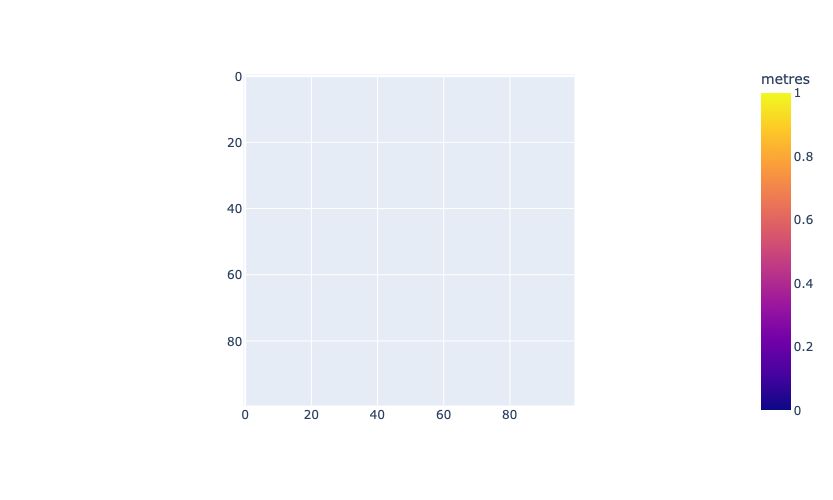

In [56]:
fig = px.imshow(
    img=distance_scaled, 
    labels={'color': 'metres'},
    width=500,
    height=500,
    aspect='equal'
)
fig.show()

In [66]:
clustering = DBSCAN(eps=0.1, metric='precomputed')

In [67]:
clustering.fit(distance_scaled)

DBSCAN(eps=0.1, metric='precomputed')

In [68]:
clustering.labels_

array([ 0, -1, -1,  2, -1, -1, -1, -1,  2,  6,  1,  2, -1,  0,  3,  2,  2,
        2, -1,  0, -1, -1, -1,  4, -1,  3, -1,  0, -1, -1, -1,  3,  1,  2,
       -1, -1, -1,  2, -1,  2, -1,  1, -1,  2, -1,  4, -1, -1, -1,  2, -1,
       -1,  5,  1,  2,  5,  6,  3, -1,  2, -1,  6, -1,  6, -1, -1,  4, -1,
       -1,  1, -1,  6,  4,  2,  3, -1, -1,  1, -1,  4, -1,  2,  0,  0,  4,
        0,  2, -1,  4, -1,  6,  2, -1, -1, -1,  2,  0, -1, -1,  2])

In [95]:
add['route'] = clustering.labels_
add['route'].value_counts()

-1    47
 2    19
 0     8
 4     7
 6     6
 1     6
 3     5
 5     2
Name: route, dtype: int64

> With `eps=0.1`, DBSCAN returned 7 routes, and identified nearly half of the addresses as noise.  
> We could try using GridSearchCV to modify `eps` to move `n_clusters` closer to the desired target.

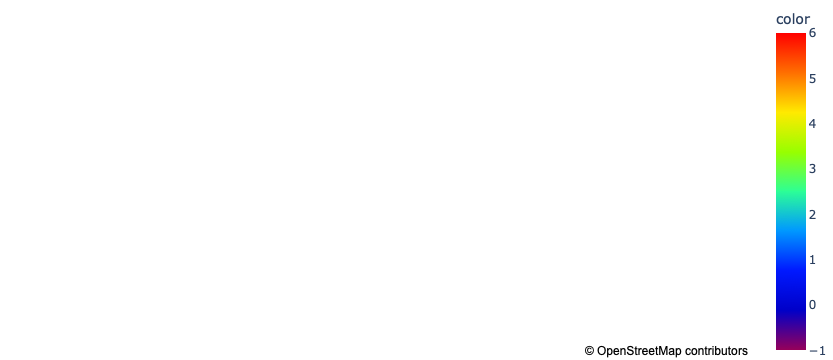

In [83]:
fig = px.scatter_mapbox(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,
    mapbox_style='open-street-map',
    color=clustering.labels_,
    color_continuous_scale=px.colors.sequential.Rainbow
)
# fig.update_geos(fitbounds='locations')
fig.update_layout(
    # title='title',
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
)
fig.show()

### Agglomerative Clustering

- `n_clusters` is a parameter.
- Uses precalculated distance matrix
- Clusters every point. There is no noise in our system.

> Need to balance the clusters based on estimated time of route completion.

- As a future feature. At first, make all routes similar in estimated time. Learn driver profiles: average package delivery time (APDT) (package/min), APDT per area in the city 1) each driver has an APDT per area, 2) each area has an APDT for all drivers. i.e. some parts of the city are slower than others and some drivers are slower in some areas than others.

In [ ]:
scalers_to_test = [
    StandardScaler(with_mean=False),
    MinMaxScaler()
]
linkages_to_test = ['complete', 'average', 'single']
params = {
    'scaler': scalers_to_test,
    'clustering__linkage': linkages_to_test
}

A manual grid search revealed a MinMaxScaler and AgglomerativeClustering with complete linkage resulted in the lowest standard deviation in the number of points per cluster.

Standard deviation of MinMaxScaler was lower than StandardScaler for all three linkage types.  
Standard deviation was highest for single linkage and lowest for complete linkage.

In [70]:
m = utilities.label_routes(40)

array([   0,   13,   14,   19,   25,   31,   57,   74,   82,   83,   96,
        108,  123,  135,  136,  144,  148,  164,  174,  179,  186,  201,
        213,  225,  242,  243,  250,  266,  269,  271,  286,  290,  299,
        324,  361,  367,  386,  390,  418,  462,  469,  471,  501,  503,
        504,  545,  566,  596,  610,  625,  629,  632,  637,  647,  668,
        688,  730,  732,  750,  763,  852,  858,  865,  876,  878,  884,
        885,  974, 1002, 1006, 1007, 1035, 1039, 1054, 1070, 1091, 1158,
       1173, 1183, 1194, 1243, 1259, 1273, 1308, 1316, 1318, 1322, 1326,
       1345, 1355, 1376, 1418, 1436, 1441, 1464, 1466, 1467, 1484, 1534,
       1537, 1541, 1579, 1600, 1602, 1692, 1693, 1700, 1734, 1745, 1746,
       1752, 1769, 1795, 1816, 1823, 1833, 1841, 1849, 1860, 1879, 1885,
       1938, 1986])

In [5]:
add['route'] = m

In [139]:
pd.concat([WAREHOUSE, gdf], axis=0)

latitude   longitude               address  \
0     51.119691 -114.031698         24 AERO DR NE   
0     51.114109 -114.162743    5532 DALWOOD WY NW   
1     50.891335 -113.914848    321 MAGNOLIA HE SE   
2     50.888362 -113.981177   165 CRANFIELD GR SE   
3     51.178209 -114.150439   2 SAGE VALLEY ME NW   
...         ...         ...                   ...   
1995  51.001674 -113.981822         5715 36 ST SE   
1996  51.070260 -114.136418  2028 URSENBACH RD NW   
1997  51.150980 -114.217089    23 ROYAL OAK PZ NW   
1998  50.980330 -113.964404         8045 48 ST SE   
1999  51.011062 -114.112082         4904 21 ST SW   

                         geometry  route  
0     POINT (-114.03170 51.11969)    NaN  
0     POINT (-114.16274 51.11411)    3.0  
1     POINT (-113.91485 50.89134)    9.0  
2     POINT (-113.98118 50.88836)   10.0  
3     POINT (-114.15044 51.17821)    0.0  
...                           ...    ...  
1995  POINT (-113.98182 51.00167)    0.0  
1996  POINT (-114.13642 51.07026)    0.0  
1997  POINT (-114.21709 51.15098)    6.0  
1998  POINT (-113.96440 50.98033)    0.0  
1999  POINT (-114.11208 51.01106)    2.0  

[2001 rows x 5 columns]

In [148]:
gdf['route'] = 0
for label in range(1, m.max()+1):
    gdf.loc[np.where(m == label)[0], 'route'] = label
    
    fig = px.scatter_mapbox(
        gdf,
        lat=gdf.geometry.y,
        lon=gdf.geometry.x,
        hover_name=gdf['route'],
        mapbox_style='open-street-map',
        color=gdf['route'].astype(object),
        color_discrete_map=color_map,
        # color_discrete_sequence=px.colors.qualitative.Plotly,
        # color_continuous_scale=px.colors.sequential.Rainbow,
        # opacity=0.85,
        width=1920,
        height=1080,
        zoom=10.3,
        center={'lat': centre[0],
                'lon': centre[1]},
        labels='route'
    )
    
    fig2 = px.scatter_mapbox(
        WAREHOUSE,
        lat=WAREHOUSE.geometry.y,
        lon=WAREHOUSE.geometry.x,
        opacity=0.85,
        color_discrete_sequence=['red']
    )
    fig.add_trace(fig2.data[0])

    fig.update_layout(
        margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
        showlegend=False
    )
    fig.write_image(f'../output/figures/fig{label}.png')

In [201]:
gdf['route'] = m

In [102]:
color_map = pd.DataFrame(px.colors.qualitative.D3 
                         + px.colors.qualitative.G10 
                         + px.colors.qualitative.T10 
                         + px.colors.qualitative.Bold).to_dict()[0]

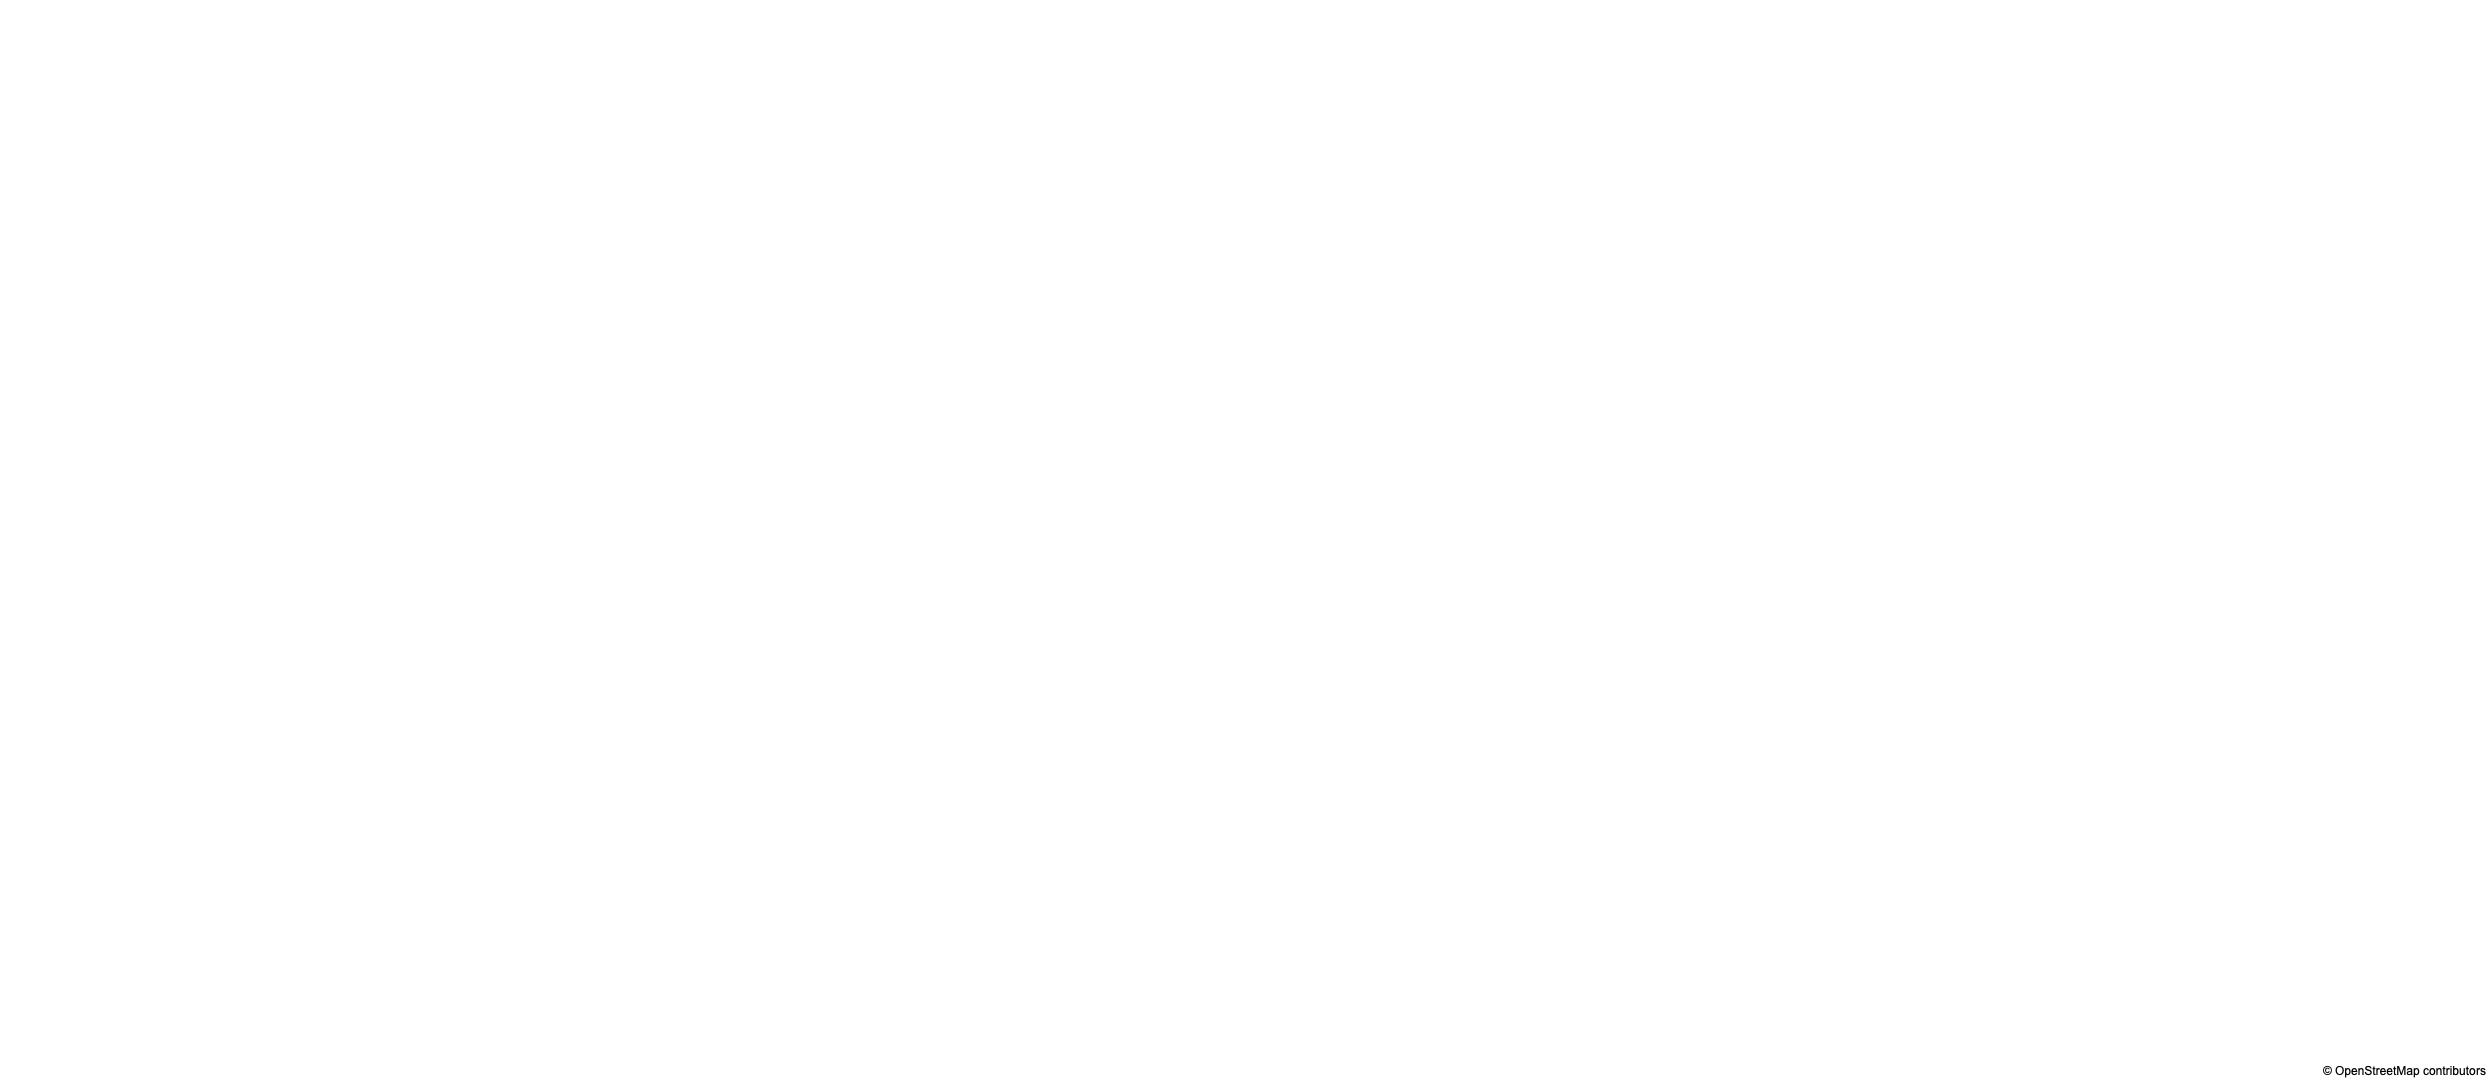

In [149]:
fig = px.scatter_mapbox(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,
    hover_name=gdf['route'],
    mapbox_style='open-street-map',
    color=gdf['route'].astype(object),
    color_discrete_sequence=px.colors.qualitative.D3,
    # color_continuous_scale=px.colors.sequential.Turbo,
    color_discrete_map=color_map,
    opacity=0.85,
    width=1920,
    height=1080,
    zoom=10.3,
    center={'lat': centre[0],
            'lon': centre[1]},
    labels='route'
)

fig2 = px.scatter_mapbox(
    WAREHOUSE,
    lat=WAREHOUSE.geometry.y,
    lon=WAREHOUSE.geometry.x,
    opacity=0.85,
    color_discrete_sequence=['red']
)

fig.add_trace(fig2.data[0])

fig.update_layout(
    margin={'r': 0, 't': 0, 'l': 0, 'b': 0},
    showlegend=False,
    coloraxis_showscale=False
)
fig.show()

In [150]:
fig.write_image('fig2.png', scale=3)

##### Optimize Clustering

In [49]:
gdf['ss_single'] = m

array([[<AxesSubplot:title={'center':'mms_avg'}>,
        <AxesSubplot:title={'center':'ss_avg'}>],
       [<AxesSubplot:title={'center':'mms_complete'}>,
        <AxesSubplot:title={'center':'ss_complete'}>],
       [<AxesSubplot:title={'center':'mms_single'}>,
        <AxesSubplot:title={'center':'ss_single'}>]], dtype=object)

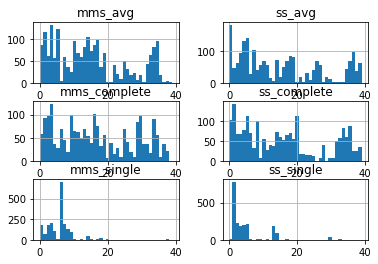

In [79]:
gdf[['mms_avg', 'ss_avg', 'mms_complete', 'ss_complete', 'mms_single', 'ss_single']].hist(bins=40)

In [74]:
stop_counts = pd.DataFrame()
for col in ['mms_avg', 'ss_avg', 'mms_complete', 'ss_complete', 'mms_single', 'ss_single']:
    stop_counts[col] = gdf[col].value_counts().sort_index()

stop_counts.head()

mms_avg  ss_avg  mms_complete  ss_complete  mms_single  ss_single
0       86     184            59          101         174         13
1      116      47            93          142          67        772
2       62      62            97           67         181        221
3      132      95           123           68         210        181
4       57     132            37           77         110        193

In [65]:
stop_counts.describe()

mms_avg      ss_avg  mms_complete  ss_complete  mms_single  \
count   40.000000   40.000000     40.000000    40.000000   40.000000   
mean    50.000000   50.000000     50.000000    50.000000   50.000000   
std     38.805894   43.125934     31.277911    34.676527  121.678644   
min      1.000000    1.000000      1.000000     1.000000    1.000000   
25%     17.000000   13.500000     26.750000    19.000000    1.000000   
50%     47.000000   45.500000     43.500000    51.500000    3.000000   
75%     81.250000   69.500000     69.250000    69.250000   23.000000   
max    132.000000  184.000000    123.000000   142.000000  699.000000   

       ss_single  
count   40.00000  
mean    50.00000  
std    134.55263  
min      1.00000  
25%      1.00000  
50%      2.00000  
75%     10.50000  
max    772.00000

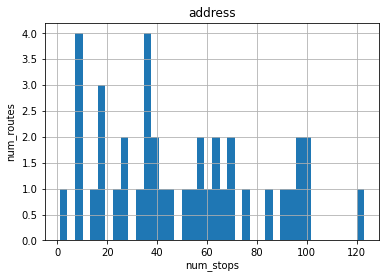

In [103]:
# It would be better for this figure to be a normal distribution with high kurtosis
fig, ax = plt.subplots()
gdf[['mms_complete', 'address']].groupby(by='mms_complete').count().hist(bins=40, ax=ax)
ax.set_xlabel('num_stops')
ax.set_ylabel('num_routes')
plt.show()

In [75]:
count_counts = stop_counts['mms_complete'].value_counts().sort_index().to_frame()
count_counts.index.name = 'num_stops'
count_counts.rename(columns={'mms_complete': 'num_routes'}, inplace=True)
count_counts

num_routes
num_stops            
1                   1
8                   1
9                   3
15                  1
17                  1
19                  2
23                  1
28                  2
33                  1
36                  1
37                  3
39                  1
40                  1
41                  1
46                  1
50                  1
53                  1
56                  2
59                  1
62                  1
65                  1
68                  1
69                  1
70                  1
76                  1
85                  1
91                  1
93                  1
96                  1
97                  1
99                  1
101                 1
123                 1

<AxesSubplot:xlabel='num_stops'>

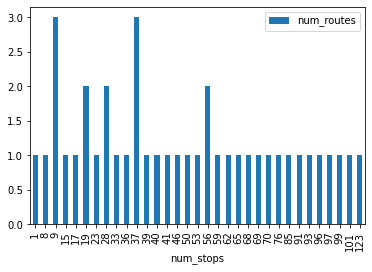

In [110]:
count_counts.plot.bar()

## TSP

Add warehouse as start location. The warehouse does not exist in OpenCalgary. Use `googlemaps.geocode()` for warehouse coordinates.

In [71]:
metadata = client.get_metadata("9zvu-p8uz")
[x['name'] for x in metadata['columns']]

['ADDRESS',
 'STREET_NAME',
 'STREET_TYPE',
 'STREET_QUAD',
 'HOUSE_NUMBER',
 'HOUSE_ALPHA',
 'ADDRESS_TYPE',
 'longitude',
 'latitude',
 'location',
 'POINT',
 'City Quadrants',
 'Ward Boundaries',
 'Calgary Communities',
 'CALGIS CENSUS COMMUNITY DIST 2015 Shape File',
 'Ward Boundaries 2013-2017']

#### Polyline

Trip routing options: I choose config 2

|config|roundtrip|source|destination|note|
|-|-|-|-|-|
|1|true|first|last|FASC stop|
|2|true|first|any|Min weight|
|3|true|any|last|starts anywhere|
|4|true|any|any|equivalent to 2|
|5|false|first|last|line between points|

from [car.lua](https://github.com/Project-OSRM/osrm-backend/blob/master/profiles/car.lua)

```Lua
-- For routing based on duration, but weighted for preferring certain roads
      weight_name = 'routability',
-- penalize turns from non-local access only segments onto local access only tags
```

[OSRM profiles: Understanding speed, weight and rate](https://github.com/Project-OSRM/osrm-backend/blob/master/docs/profiles.md#understanding-speed-weight-and-rate) 

In [177]:
OSRM_API = osrm.OSRM()

In [178]:
route_table=OSRM_API.tsp(
    routes=gdf,
    source=WAREHOUSE
)

1.748831033706665
1.4535841941833496
1.6026663780212402
0.819659948348999
0.32140016555786133
0.2715010643005371
0.4211409091949463
0.3480219841003418
0.1376330852508545
0.6194660663604736
0.3271980285644531
0.4574110507965088
0.30674099922180176
0.5072877407073975
0.4423050880432129
0.3018498420715332
0.5836300849914551
0.5539519786834717
0.22649502754211426
0.3395819664001465
0.09718513488769531
0.26775026321411133
0.11518597602844238
0.20001792907714844
0.0627140998840332
0.5125730037689209
0.21814274787902832
0.1503150463104248
0.09227204322814941
0.683082103729248
0.6231250762939453
0.24537277221679688
0.19303297996520996
0.12846827507019043
0.7349250316619873
0.37404489517211914
0.0758829116821289
0.19044089317321777
0.16054487228393555
0.026782989501953125


In [182]:
route_table.to_csv('route_table.csv', index=False)

In [219]:
route_table = pd.read_csv('route_table.csv')
route_table['waypoints'] = route_table['waypoints'].apply(ast.literal_eval)
# route_table['duration'] = pd.to_timedelta(route_table['duration'], unit='s')
route_table['duration'] = route_table['duration'] / 60
route_table['distance'] = route_table['distance'] / 1000
route_table.head(2)

geometry  distance    duration  \
0  _e_wHp__wT`DaGV_@dBmBd@a@\YnAw@tAo@r@Ur@Ot@Mr@...   89.5240  136.998333   
1  _e_wHp__wT`DaGV_@dBmBd@a@\YnAw@tAo@r@Ur@Ot@Mr@...   81.3614  161.358333   

   weight                                          waypoints  route  stops  
0  8320.3  [{'waypoint_index': 0, 'trips_index': 0, 'loca...      0     59  
1  9771.8  [{'waypoint_index': 0, 'trips_index': 0, 'loca...      1     93

In [190]:
import ast

In [202]:
gdf = utilities.parse_routes(route_table=route_table, addresses=gdf)
gdf = utilities.df_to_geodf(gdf)
gdf

address   longitude   latitude  \
5          103 DEERMONT WY SE -114.018978  50.928064   
132         63 DEERPATH RD SE -114.025273  50.924253   
183    9515 ASSINIBOINE RD SE -114.051717  50.967926   
203      868 QUEENSLAND DR SE -114.017383  50.935251   
291   50 LAKE CHRISTINA CL SE -114.038803  50.940734   
...                       ...         ...        ...   
1649            5212 18 AV NW -114.167524  51.078067   
1680     2804 MONTALBAN CR NW -114.153922  51.076770   
1918       4915 VICEROY DR NW -114.158936  51.095974   
1969            4917 20 AV NW -114.162385  51.076615   
675             9370 84 ST SE -113.911593  50.970994   

                         geometry  route  r_index  waypoint_index  
5     POINT (-114.01898 50.92806)      0        1              49  
132   POINT (-114.02527 50.92425)      0        2              51  
183   POINT (-114.05172 50.96793)      0        3               7  
203   POINT (-114.01738 50.93525)      0        4              57  
291   POINT (-114.03880 50.94073)      0        5              25  
...                           ...    ...      ...             ...  
1649  POINT (-114.16752 51.07807)     38       20              16  
1680  POINT (-114.15392 51.07677)     38       21              21  
1918  POINT (-114.15894 51.09597)     38       22               5  
1969  POINT (-114.16239 51.07661)     38       23              15  
675   POINT (-113.91159 50.97099)     39        1               1  

[1974 rows x 7 columns]

In [204]:
def plot_routes(route_table, addresses, warehouse):
    """
    Plot routes with paths.
    
    Parameters
    ----------
    route_table: Dataframe
        The output of OSRM.tsp_polylines()
    
    Returns
    -------
    None
    
    TODO
    ----
    - See if folium does a better job with plotting
    - Route based colour schemes
    """
    
    fig = go.Figure()
    traces = []
    
    for i, route in route_table.iterrows():
        # Plot route
        t1 = polyline_to_geodf(route['geometry'])

        fig.add_scattermapbox(
            mode="lines",
            lat=t1.geometry.y,
            lon=t1.geometry.x,
            name=f'Route {i}', 
            # fill='toself'
        )
        fig.
    traces.append(px.scatter_mapbox(
        addresses,
        lat=addresses.geometry.y,
        lon=addresses.geometry.x,
        color='route',
        hover_name='waypoint_index',
        hover_data=['address']
    ).data[0])
    
    traces.append(px.scatter_mapbox(
        warehouse,
        lat=warehouse.geometry.y,
        lon=warehouse.geometry.x,
        hover_data=['address']
    ).data[0])
    
    fig.add_traces(traces)
    
    fig.update_layout(
        margin ={'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'style': "open-street-map",
            'center': {'lat': centre[0],
                       'lon': centre[1]},
            'zoom': 8
        },
        coloraxis={'colorscale': 'rainbow'}
    )

    fig.show()
    return

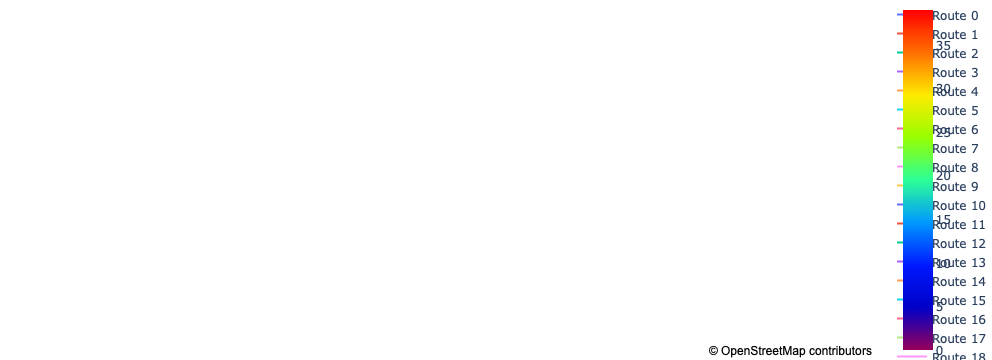

In [203]:
utilities.plot_routes(route_table, gdf, WAREHOUSE)

In [11]:
route_table.head(2)

geometry  distance  duration  \
0  _e_wHp__wT`DaGV_@dBmBd@a@\YnAw@tAo@r@Ur@Ot@Mr@...   89524.0    8219.9   
1  _e_wHp__wT`DaGV_@dBmBd@a@\YnAw@tAo@r@Ur@Ot@Mr@...   81361.4    9681.5   

   weight                                          waypoints  route  stops  
0  8320.3  [{'waypoint_index': 0, 'trips_index': 0, 'loca...      0     59  
1  9771.8  [{'waypoint_index': 0, 'trips_index': 0, 'loca...      1     93

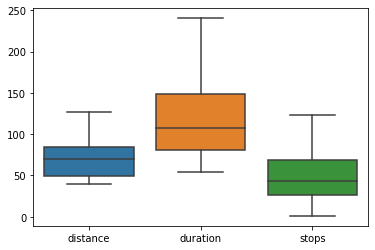

In [220]:
fig, ax = plt.subplots()
sns.boxplot(data=route_table[['distance', 'duration', 'stops']], ax=ax)
plt.show()

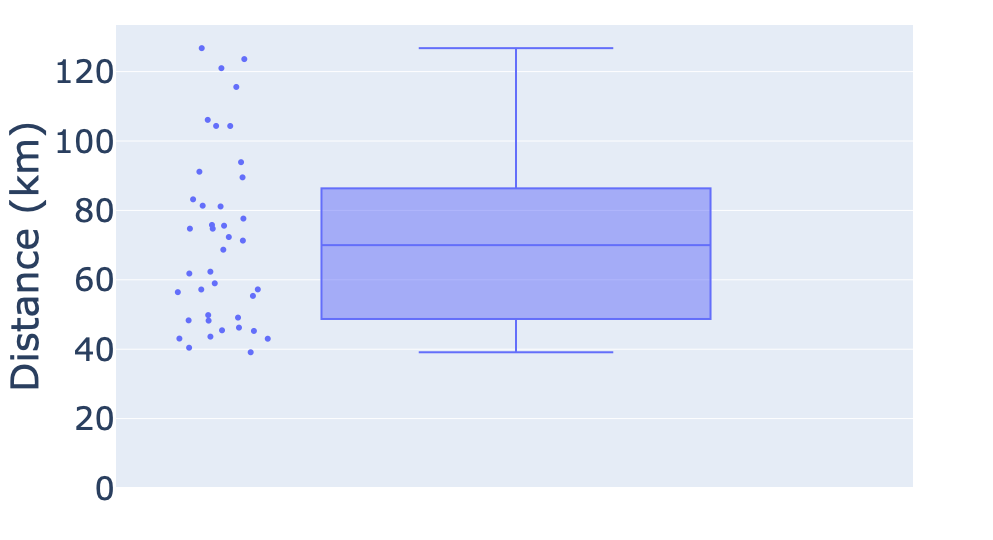

In [266]:
fig = px.box(
    route_table,
    y='distance',
    points="all",
    width=540,
    height=540
)
fig.update_layout(
    margin ={'t':25,'b':25},
    yaxis_title='Distance (km)',
    yaxis={'rangemode': 'tozero'},
    font={'size': 32}
)
fig.show()
fig.write_image('../output/figures/distance_box.png')

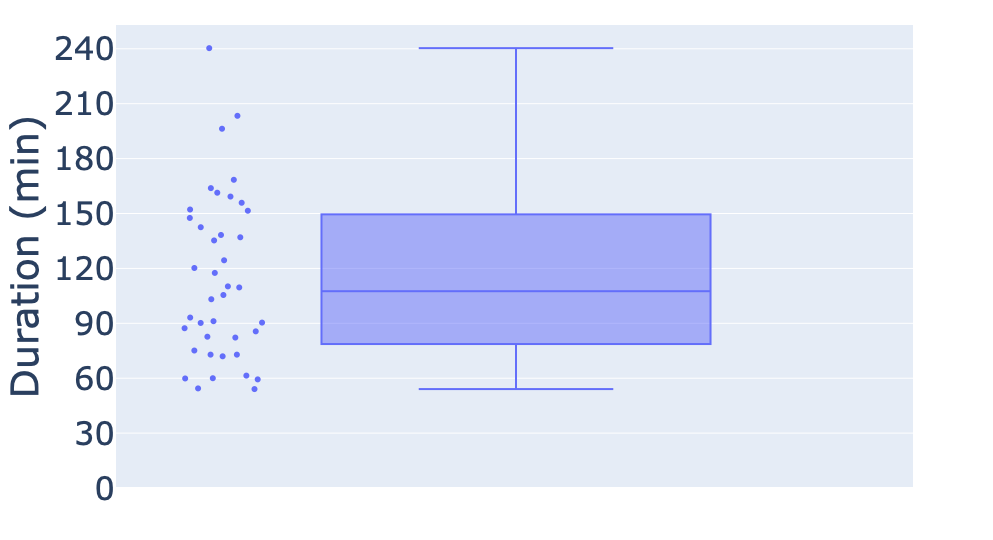

In [273]:
fig = px.box(
    route_table,
    y='duration',
    points="all",
    width=540,
    height=540
)
fig.update_layout(
    margin ={'t':25,'b':25},
    yaxis_title='Duration (min)',
    yaxis={'rangemode': 'tozero',
          'dtick': 30},
    font={'size': 32}
)
fig.show()
fig.write_image('../output/figures/duration_box.png')

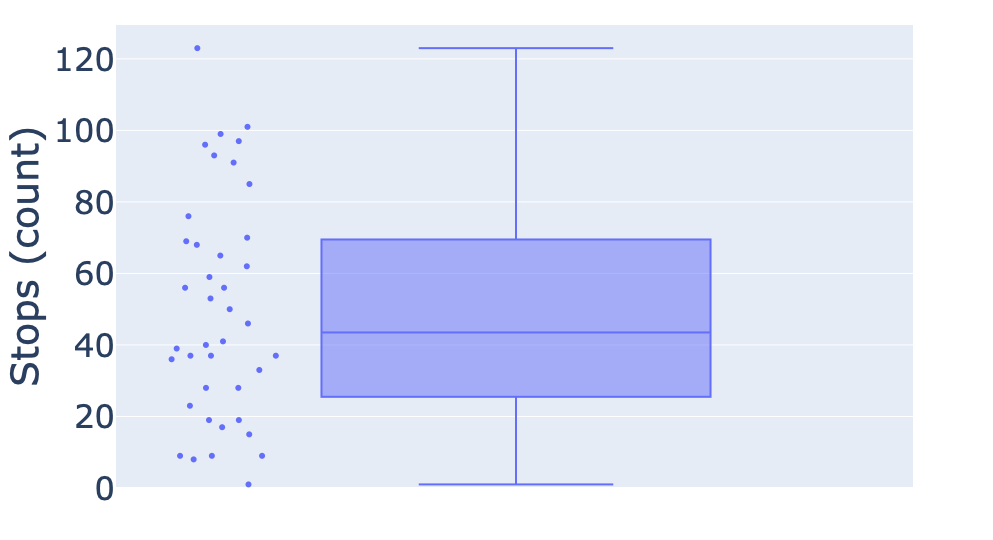

In [264]:
fig = px.box(
    route_table,
    y='stops',
    points="all",
    width=540,
    height=540
)
fig.update_layout(
    margin ={'t':25,'b':25},
    yaxis_title='Stops (count)',
    yaxis={'rangemode': 'tozero'},
    font={'size': 32}
)
fig.show()
fig.write_image('../output/figures/stops_box.png')

In [247]:
route_table[['distance', 'duration', 'stops']].describe()

distance    duration       stops
count   40.000000   40.000000   40.000000
mean    71.596195  114.706750   50.000000
std     25.243536   45.278247   31.277911
min     39.115500   54.055000    1.000000
25%     48.910000   80.437500   26.750000
50%     69.990900  107.531667   43.500000
75%     84.772450  148.553333   69.250000
max    126.760700  240.351667  123.000000

In [183]:
# Quickest route
(route_table[route_table['duration'] == route_table['duration'].min()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration  weight  route  stops
24   43624.8    3243.3  3243.3     24      9

In [184]:
# Shortest route
(route_table[route_table['distance'] == route_table['distance'].min()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration  weight  route  stops
23   39115.5    4372.3  4508.8     23     28

In [185]:
# Fewest stops
(route_table[route_table['stops'] == route_table['stops'].min()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration  weight  route  stops
39   62342.2    3591.3  3591.3     39      1

In [186]:
# Sloweset route
(route_table[route_table['duration'] == route_table['duration'].max()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration   weight  route  stops
3  120986.2   14421.1  21064.3      3    123

In [187]:
# Longest route
(route_table[route_table['distance'] == route_table['distance'].max()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration   weight  route  stops
9  126760.7   11778.9  11941.2      9     99

In [188]:
# Most stops
(route_table[route_table['stops'] == route_table['stops'].max()]
 .drop(columns=['geometry', 'waypoints']))

distance  duration   weight  route  stops
3  120986.2   14421.1  21064.3      3    123

In [27]:
sns.set_context('talk')

In [40]:
bins = 'auto'

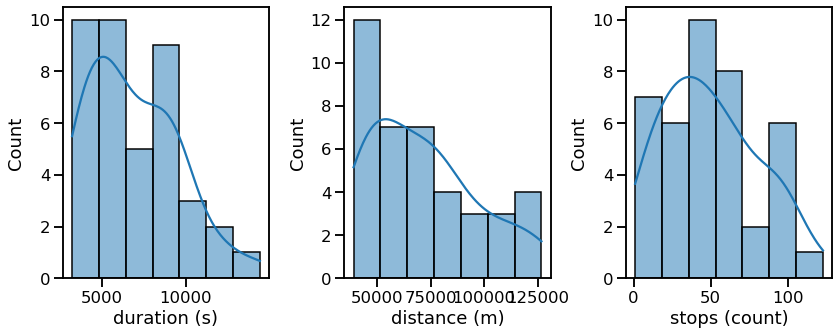

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
sns.histplot(route_table['duration'], bins=bins, kde=True, ax=axes[0])
axes[0].set_xlabel('duration (s)')
sns.histplot(route_table['distance'], bins=bins, kde=True, ax=axes[1])
axes[1].set_xlabel('distance (m)')
sns.histplot(route_table['stops'], bins=bins, kde=True, ax=axes[2])
axes[2].set_xlabel('stops (count)')
plt.tight_layout()
plt.show()

## Folium

In [47]:
# plot trip
m = folium.Map(location=(51.07677, -114.15392), zoom_start=13)
for i, route in route_table.iterrows():
    pl = polyline.decode(route['geometry'])
    folium.PolyLine(pl).add_to(m)
m